In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch

import efield
import geometry

from importlib import reload

100%|██████████| 70/70 [00:00<00:00, 96.89it/s] 


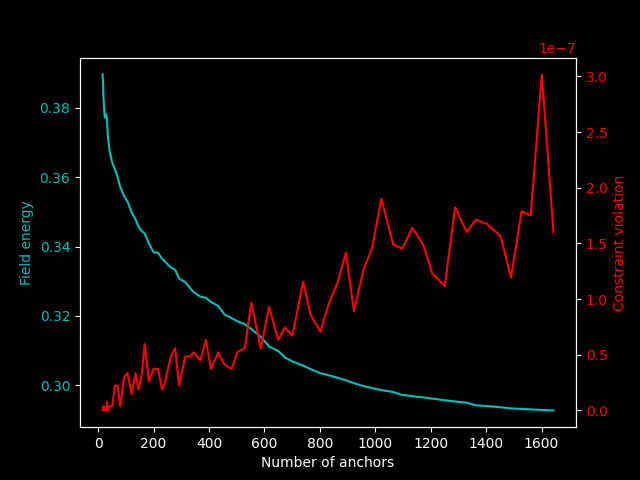

In [47]:
reload(geometry)
reload(efield.geometry)
reload(efield)


def dipole(
    box1: geometry.Box,
    box2: geometry.Box,
    box1_potential: float,
    box2_potential: float,
    universe: geometry.Box,
    **fit_kwargs
) -> efield.Potential:
    box1_locations3d = box1.grid(2, 2, 2)
    box2_locations3d = box2.grid(2, 2, 2)

    conductor_locations3d = torch.vstack((box1_locations3d, box2_locations3d))
    conductor_potentials = torch.tensor(
        [box1_potential] * len(box1_locations3d)
        + [box2_potential] * len(box2_locations3d),
    )

    return efield.fit_radial_basis_function_potential(
        universe, conductor_locations3d, conductor_potentials, **fit_kwargs
    )


box1 = geometry.Box(-0.03, 0.03, -0.03, 0.03, -0.37, -0.43)
box1_potential = -1.0
box2 = geometry.Box(-0.03, 0.03, -0.03, 0.03, 0.37, 0.43)
box2_potential = 1.0
universe = geometry.Box(-0.7, 0.7, -0.7, 0.7, -1, 1)
potential = dipole(box1, box2, box1_potential, box2_potential, universe)

/var/folders/ml/1xcwbqs94c92yq4154xk0yz40000gr/T/ipykernel_46388/521113725.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


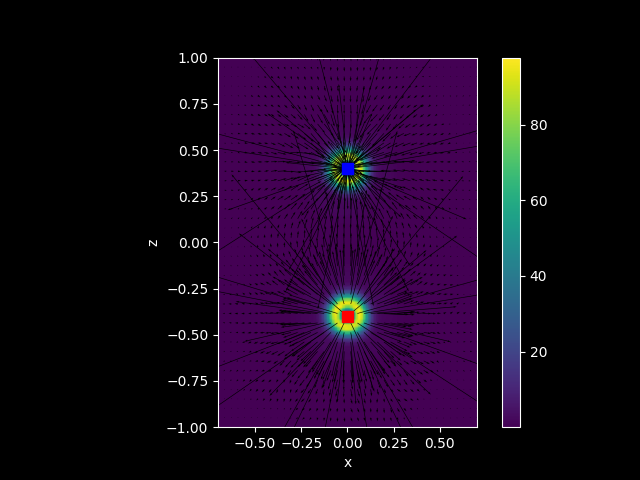

In [53]:
def show_xz_cross_section(
    box1: geometry.Box,
    box2: geometry.Box,
    universe: geometry.Box,
    potential: efield.Potential,
    y: float,
):
    fig, ax = plt.subplots(1, 1)

    # Show the potential function as a potential heat map.
    X, Z = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 100),
        torch.linspace(universe.zmin, universe.zmax, 100),
        indexing="xy",
    )
    xyz = torch.stack((X.flatten(), y + 0 * X.flatten(), Z.flatten())).T
    if False:
        # Show the potential function.
        V = potential(xyz)
    elif True:
        # Show the local energy.
        Vx, Vy, Vz = potential.field(xyz)
        V = Vx**2 + Vy**2 + Vz**2
    else:
        # Show the magnitude of the laplacian.
        V = potential.laplacian(xyz).abs().log()

    img = ax.imshow(
        V.reshape(X.shape).detach(),
        extent=(universe.xmin, universe.xmax, universe.zmin, universe.zmax),
        origin="lower",
    )

    # Show the field as a quiver plot.
    X_field, Z_field = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 40),
        torch.linspace(universe.zmin, universe.zmax, 40),
        indexing="xy",
    )
    xyz_field = torch.stack(
        (X_field.flatten(), X_field.flatten() * 0 + y, Z_field.flatten())
    ).T
    Vx, _, Vz = potential.field(xyz_field).detach().numpy()
    ax.quiver(
        xyz_field[:, 0], xyz_field[:, 2], Vx, Vz, angles="xy", units="xy", scale=10
    )

    fig.colorbar(img, ax=ax)

    ax.add_artist(
        plt.Rectangle(
            (box1.xmin, box1.zmin),
            box1.xmax - box1.xmin,
            box1.zmax - box1.zmin,
            color="r",
        )
    )
    ax.add_artist(
        plt.Rectangle(
            (box2.xmin, box2.zmin),
            box2.xmax - box2.xmin,
            box2.zmax - box2.zmin,
            color="b",
        ),
    )
    ax.set_xlabel("x")
    ax.set_ylabel("z")


show_xz_cross_section(box1, box2, universe, potential, 0)

Compare recovered field against the field predicted by Coulomb's law.


The latter field assumes the charges are known. But in the actual problem we're
solving, the charges are not known. Only their potential is known. To compute
the Coulomb potential, we plug in the potential at the charge as ther charge
itself.  So this comparison is very subjective.

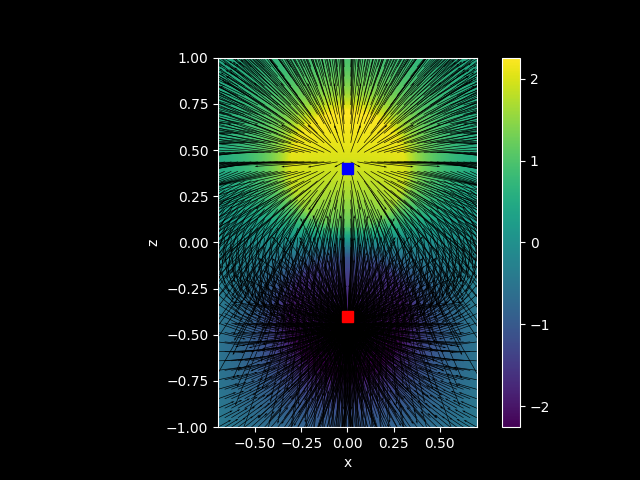

In [7]:
coulomb_potential = efield.CoulombPotential(
    torch.stack((box1.center(), box2.center())),
    torch.tensor((box1_potential, box2_potential)),
    None,
)

show_xz_cross_section(box1, box2, universe, coulomb_potential, 0)

Visualize the recoverdd field in 3D:

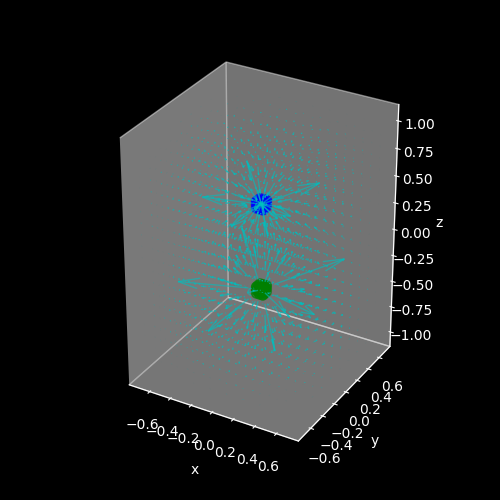

In [8]:
def show_field(
    box1: geometry.Box,
    box2: geometry.Box,
    universe: geometry.Box,
    potential: efield.Potential,
):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")

    box1_locations3d = box1.grid(3, 3, 3)
    ax.scatter(
        box1_locations3d[:, 0],
        box1_locations3d[:, 1],
        box1_locations3d[:, 2],
        s=50,
        color="g",
    )
    box2_locations3d = box2.grid(3, 3, 3)
    ax.scatter(
        box2_locations3d[:, 0],
        box2_locations3d[:, 1],
        box2_locations3d[:, 2],
        s=50,
        color="b",
    )
    xyz = universe.grid(10, 10, 20)

    Vx, Vy, Vz = potential.field(xyz).detach()
    ax.quiver(
        xyz[:, 0],
        xyz[:, 1],
        xyz[:, 2],
        Vx,
        Vy,
        Vz,
        lw=1,
        length=0.1,
        alpha=0.6,
        color="c",
    )
    ax.grid(False)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.axis("square")


show_field(box1, box2, universe, potential)

# Measure charges

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


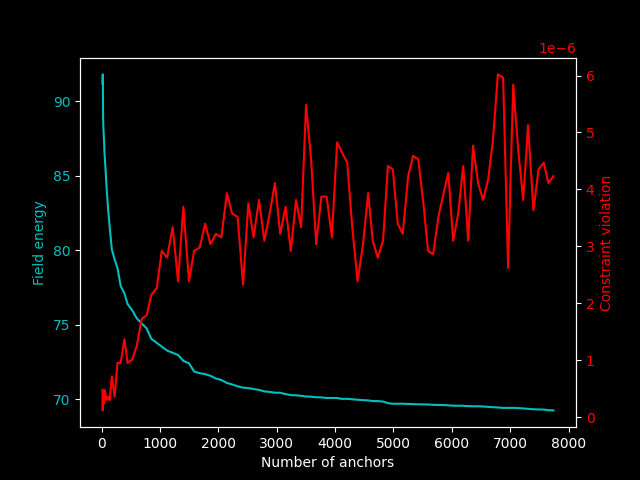

In [40]:
def potentials_at_centers(
    box1: geometry.Box,
    box2: geometry.Box,
    box1_charge: float,
    box2_charge: float,
) -> efield.Potential:
    box1_locations3d = box1.grid(2, 2, 2)
    box2_locations3d = box2.grid(2, 2, 2)

    charge_locations3d = torch.vstack((box1_locations3d, box2_locations3d))
    charges = torch.tensor(
        [box1_charge] * len(box1_locations3d) + [box2_charge] * len(box2_locations3d),
    )
    coulomb_potential = efield.CoulombPotential(charge_locations3d, charges, None)

    return coulomb_potential(torch.stack((box1.center(), box2.center())))


box1_potential, box2_potential = potentials_at_centers(box1, box2, +1.0, -1.0)
potential = dipole(
    box1,
    box2,
    box1_potential,
    box2_potential,
    universe,
    num_rounds=100,
    anchor_width_scale=0.2,
)

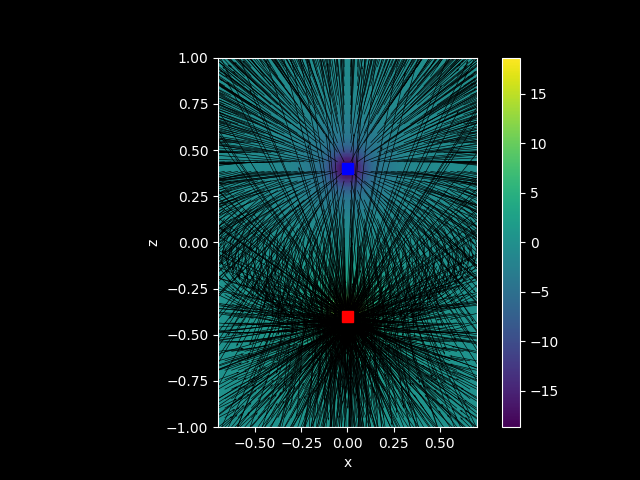

In [41]:
show_xz_cross_section(box1, box2, universe, potential, 0)

In [49]:
box1_recovered_charge = potential.enclosed_charge(box1.expand(1.5))
box2_recovered_charge = potential.enclosed_charge(box2.expand(1.5))
print(box1_recovered_charge, box2_recovered_charge)

tensor(-0.3624, grad_fn=<AddBackward0>) tensor(-0.3522, grad_fn=<AddBackward0>)


In [50]:
box1_recovered_charge = potential.enclosed_charge(box1.expand(2.0))
box2_recovered_charge = potential.enclosed_charge(box2.expand(2.0))
print(box1_recovered_charge, box2_recovered_charge)

tensor(-0.6405, grad_fn=<AddBackward0>) tensor(-0.6297, grad_fn=<AddBackward0>)


In [51]:
box1_recovered_charge = potential.enclosed_charge(box1.expand(3.0))
box2_recovered_charge = potential.enclosed_charge(box2.expand(3.0))
print(box1_recovered_charge, box2_recovered_charge)

tensor(-0.9586, grad_fn=<AddBackward0>) tensor(-0.9679, grad_fn=<AddBackward0>)


In [52]:
box1_recovered_charge = potential.enclosed_charge(box1.expand(6.0))
box2_recovered_charge = potential.enclosed_charge(box2.expand(6.0))
print(box1_recovered_charge, box2_recovered_charge)

tensor(-0.7932, grad_fn=<AddBackward0>) tensor(-0.7833, grad_fn=<AddBackward0>)


In [55]:
import numpy as np

n = 1000
x = np.random.rand(n)
((x**2).sum() - x.sum() ** 2) / (2 * n)

-125.36988956059864

In [57]:
2 * n * x.var()

169.87412081298703

In [61]:
((x - x.mean()) ** 2).sum() * 2

169.87412081298703

In [63]:
((x[:, None] - x[None, :]) ** 2).sum()

169874.12081298698